#Notes

- takes jpg 256 as input -> make png 256 set

- current jpg 256 best: MobileNet alpha 0.5, 70 epochs

# Code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Datasets/Massachusetts_Roads_jpg_256')
os.getcwd()

'/content/drive/My Drive/Datasets/Massachusetts_Roads_jpg_256'

In [ ]:
!ls -l . | egrep -c '^-'

14


In [ ]:
# Unzip Dataset
!unzip png.zip

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, concatenate
from keras.layers import UpSampling2D, Input, Concatenate
from keras.models import Model , load_model
from keras.applications import MobileNetV2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.metrics import Recall, Precision 
from keras import backend as K

In [ ]:
# Set seeds for better reproducability
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparameters for the model
IMG_SIZE = 256
EPOCHS = 70
BATCH = 32
LR = 1e-4
PATH = "/content/drive/My Drive/Datasets/Massachusetts_Roads_jpg_256/"

In [ ]:
# Load and assign the data used for training, validation, and testing
def load_data(path, split=0.1):
    images_list = sorted(glob(os.path.join(path, "train/*")))
    masks_list = sorted(glob(os.path.join(path, "train_labels/*")))

    tot_size = len(images_list)
    val_size = int(split * tot_size)
    test_size = int(split * tot_size)

    x_train, x_val = train_test_split(images_list, test_size=val_size, random_state=42)
    y_train, y_val = train_test_split(masks_list, test_size=val_size, random_state=42)

    x_train, x_test = train_test_split(x_train, test_size=test_size, random_state=42)
    y_train, y_test = train_test_split(y_train, test_size=test_size, random_state=42)

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [ ]:
# Read, resize and  normalize an aerial image
def read_img(path):
    path = path.decode()
    tmp = cv2.imread(path, cv2.IMREAD_COLOR)
    tmp = cv2.resize(tmp, (IMG_SIZE, IMG_SIZE))
    tmp = tmp/255.0
    return tmp

# Read, resize, normalize and add dimension to an aerial image mask
def read_mask(path):
    path = path.decode()
    tmp = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    tmp = cv2.resize(tmp, (IMG_SIZE, IMG_SIZE))
    tmp = tmp/255.0
    tmp = np.expand_dims(tmp, axis=-1)
    return tmp

In [ ]:
def tf_parse(a, b):
    def _parse(a, b):
        a = read_img(a)
        b = read_mask(b)
        return a, b

    a, b = tf.numpy_function(_parse, [a, b], [tf.float64, tf.float64])
    a.set_shape([IMG_SIZE, IMG_SIZE, 3])
    b.set_shape([IMG_SIZE, IMG_SIZE, 1])
    return a, b

def tf_dataset(a, b, batch=32):
    data = tf.data.Dataset.from_tensor_slices((a, b))
    data = data.map(tf_parse)
    data = data.batch(batch)
    data = data.repeat()
    return data

In [ ]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data(PATH)

print("Training data: ", len(x_train))
print("Validation data: ", len(x_val))
print("Testing data: ", len(x_test))

Training data:  888
Validation data:  110
Testing data:  110


In [ ]:
def read_and_rgb(a):
    a = cv2.imread(a)
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return a

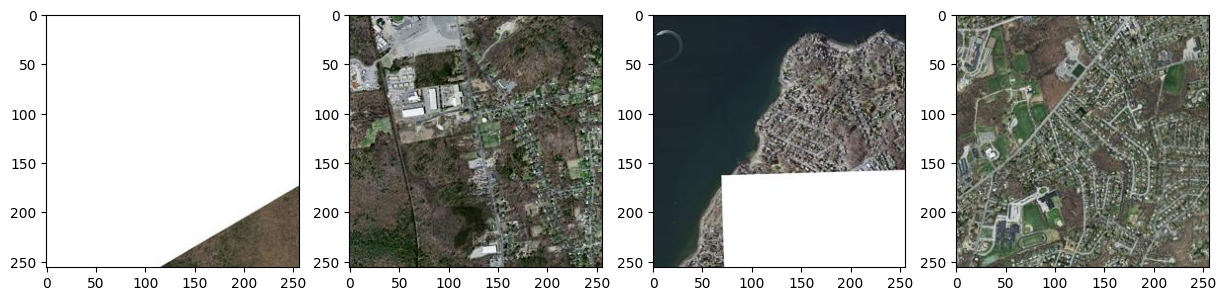

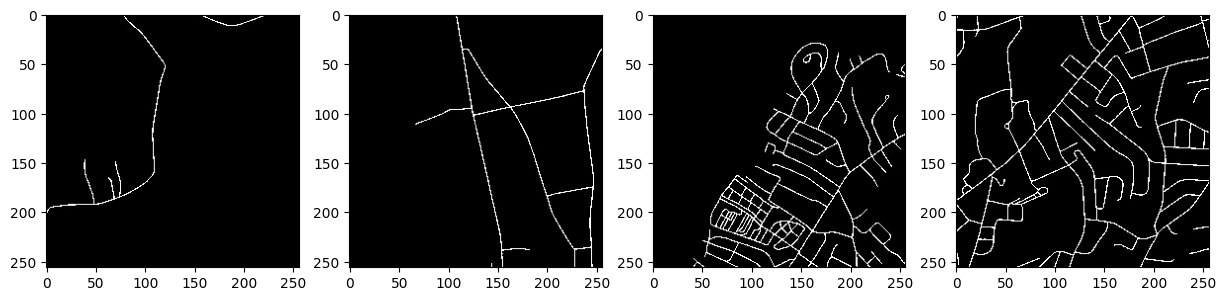

In [ ]:
fig = plt.figure(figsize=(15, 15))
x = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(x_train[0]))

x = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(x_train[1]))
imgplot.set_clim(0.0, 0.7)

x = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(x_train[2]))
imgplot.set_clim(0.0, 1.4)

x = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(x_train[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
x = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(y_train[0]))

x = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(y_train[1]))
imgplot.set_clim(0.0, 0.7)

x = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(y_train[2]))
imgplot.set_clim(0.0, 1.4)

x = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(y_train[3]))
imgplot.set_clim(0.0, 1.4)

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def res_block(in_put, n_kernels):

    conv = BatchNormalization(axis=3)(in_put)
    conv = Conv2D(n_kernels, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = BatchNormalization(axis=3)(conv)
    conv = Conv2D(n_kernels, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)

    conv_shortcut = Conv2D(n_kernels, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(in_put)
    conv_shortcut = BatchNormalization(axis=3)(conv_shortcut)

    conv = Add()([conv, conv_shortcut])

    return conv

def model(pretrained_weights = None):

    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_image")

    # Level 1
    conv1 = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Add()([conv1, inputs])

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Level 2
    conv2 = res_block(pool1, n_kernels = 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Level 3
    conv3 = res_block(pool2, n_kernels = 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Level 4
    conv4 = res_block(pool3, n_kernels = 512) 
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Level 5
    conv5 = res_block(pool4, n_kernels = 1024) 
    drop5 = Dropout(0.5)(conv5)

    # Level 6
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = res_block(merge6, n_kernels = 512)

    # Level 7
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3, up7], axis = 3)
    conv7 = res_block(merge7, n_kernels = 256)

    # Level 8
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))    
    merge8 = concatenate([conv2, up8], axis = 3)
    conv8 = res_block(merge8, n_kernels = 128)

    # Level 9
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis = 3)
    conv9 = res_block(merge9, n_kernels = 3)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, (1, 1), padding="same")(conv9)
    conv10 = Activation("sigmoid")(conv10)

    model = Model(inputs = inputs, outputs = conv10)

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    #if(pretrained_weights):
    	#model.load_weights(pretrained_weights)

    return model

In [ ]:
def model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_list = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    fil = [48, 64, 96, 128]
    xt = encoder_output
    for i in range(1, len(skip_connection_list)+1, 1):
        xt_skip = encoder.get_layer(skip_connection_list[-i]).output
        xt = UpSampling2D((2, 2))(xt)
        xt = Concatenate()([xt, xt_skip])
        
        xt = Conv2D(fil[-i], (3, 3), padding="same")(xt)
        xt = BatchNormalization()(xt)
        xt = Activation("relu")(xt)
        
        xt = Conv2D(fil[-i], (3, 3), padding="same")(xt)
        xt = BatchNormalization()(xt)
        xt = Activation("relu")(xt)
        
    xt = Conv2D(1, (1, 1), padding="same")(xt)
    xt = Activation("sigmoid")(xt)
    
    model = Model(inputs, xt)
    return model

In [ ]:
model = model()
model.summary()

2019640/2019640 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 16  64          ['Conv1[0][0]']                  
                             

In [ ]:
from keras.utils import plot_model
# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=False, rankdir='TB')

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

### Run this module only while loading the pre-trained model.

In [ ]:
model = load_model('/content/drive/My Drive/Datasets/Massachusetts_Roads_jpg_256/MobileUnet_with_weight_alpha05_70_epochs.h5',custom_objects={'dice_loss': dice_loss,'dice_coef':dice_coef})
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 16  64          ['Conv1[0][0]']                  
                                )                                                           

### Else

In [ ]:
train_data = tf_dataset(x_train, y_train, batch=BATCH)
valid_data = tf_dataset(x_val, y_val, batch=BATCH)

In [ ]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [ ]:
train_steps = len(x_train)//BATCH
valid_steps = len(x_val)//BATCH

if len(x_train) % BATCH != 0:
    train_steps += 1
if len(x_val) % BATCH != 0:
    valid_steps += 1



In [ ]:
model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS,
    #epochs=5,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/70
28/28 [==============================] - 59s 702ms/step - loss: 0.8659 - dice_coef: 0.1343 - recall_4: 0.4289 - precision_4: 0.2695 - val_loss: 0.8923 - val_dice_coef: 0.1073 - val_recall_4: 0.9978 - val_precision_4: 0.1625 - lr: 1.0000e-04
Epoch 2/70
28/28 [==============================] - 17s 595ms/step - loss: 0.8022 - dice_coef: 0.1978 - recall_4: 0.5269 - precision_4: 0.3466 - val_loss: 0.8736 - val_dice_coef: 0.1259 - val_recall_4: 0.9453 - val_precision_4: 0.1882 - lr: 1.0000e-04
Epoch 3/70
28/28 [==============================] - 17s 619ms/step - loss: 0.7723 - dice_coef: 0.2277 - recall_4: 0.4474 - precision_4: 0.3908 - val_loss: 0.8557 - val_dice_coef: 0.1428 - val_recall_4: 0.4305 - val_precision_4: 0.3470 - lr: 1.0000e-04
Epoch 4/70
28/28 [==============================] - 18s 632ms/step - loss: 0.7501 - dice_coef: 0.2499 - recall_4: 0.3993 - precision_4: 0.4208 - val_loss: 0.8577 - val_dice_coef: 0.1399 - val_recall_4: 0.2117 - val_precision_4: 0.4588 - lr: 1.0

For saving weights and model for future use.

In [ ]:
model.save_weights("/content/drive/My Drive/Datasets/Massachusetts_Roads/MobileUNetW_alpha035_70_epochs.h5")

model.save("/content/drive/My Drive/Datasets/Massachusetts_Roads/MobileUnet_with_weight_alpha035_70_epochs.h5")

In [ ]:
test_data = tf_dataset(x_test, y_test, batch=BATCH)

test_steps = (len(x_test)//BATCH)
if len(x_test) % BATCH != 0:
    test_steps += 1

model.evaluate(test_data, steps=test_steps)

4/4 [==============================] - 1s 173ms/step - loss: 0.6343 - dice_coef: 0.3675 - recall_4: 0.2370 - precision_4: 0.5115


[0.6342923045158386,
 0.36753982305526733,
 0.23701685667037964,
 0.5115310549736023]

In [ ]:
def read_img(path):
    xt = cv2.imread(path, cv2.IMREAD_COLOR)
    xt = cv2.cvtColor(xt, cv2.COLOR_BGR2RGB)
    xt = cv2.resize(xt, (IMG_SIZE, IMG_SIZE))
    xt = xt/255.0
    return xt

def read_mask(path):
    xt = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    xt = cv2.resize(xt, (IMG_SIZE, IMG_SIZE))
    xt = np.expand_dims(xt, axis=-1)
    xt = xt/255.0
    return xt

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

1/1 [==============================] - 0s 40ms/step


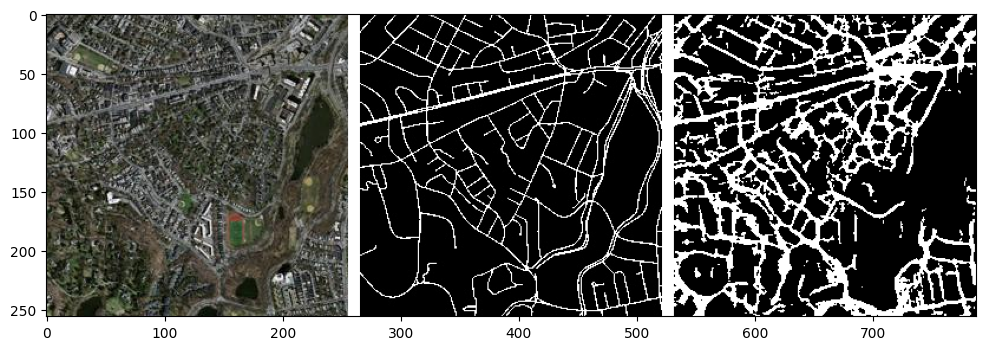

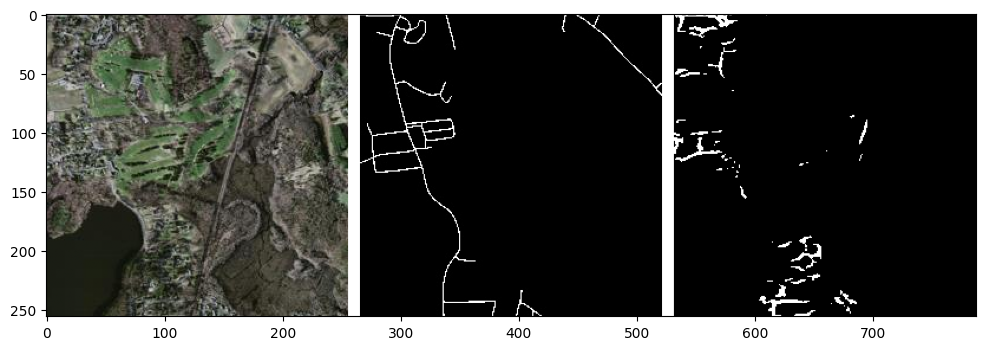

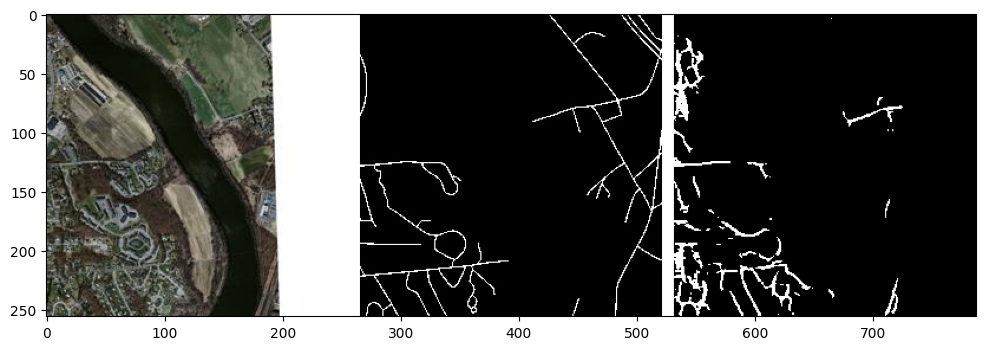

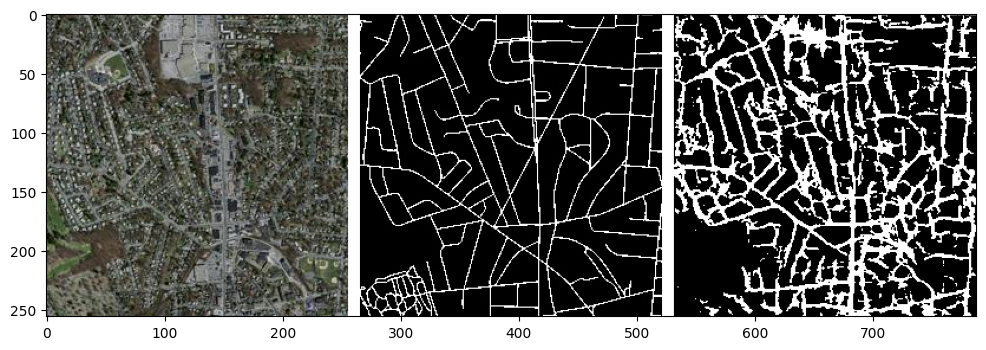

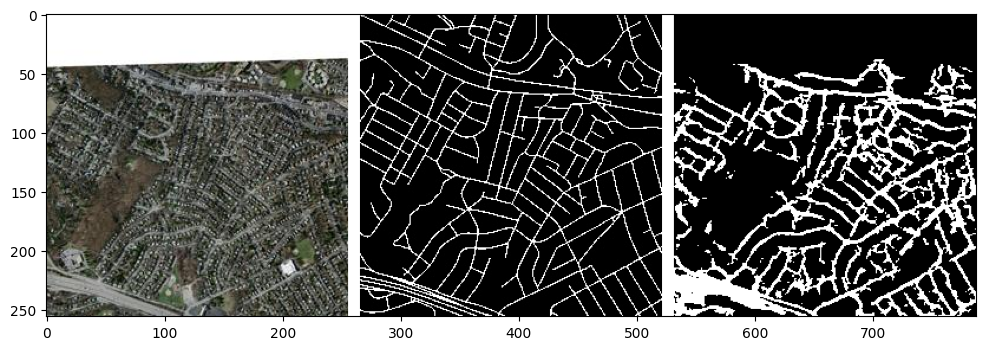

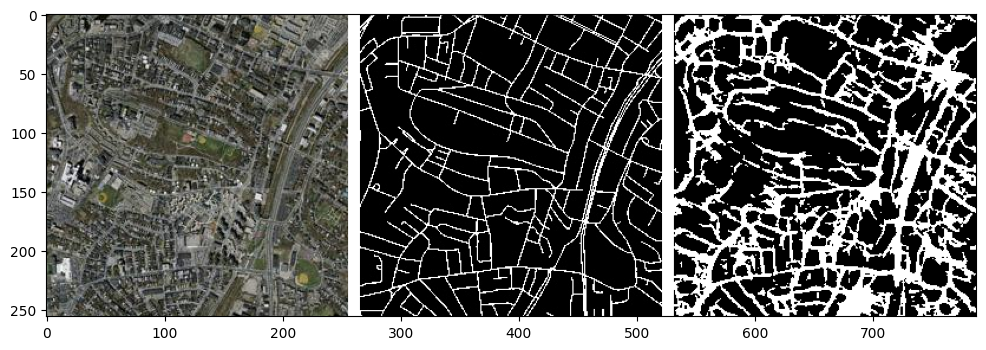

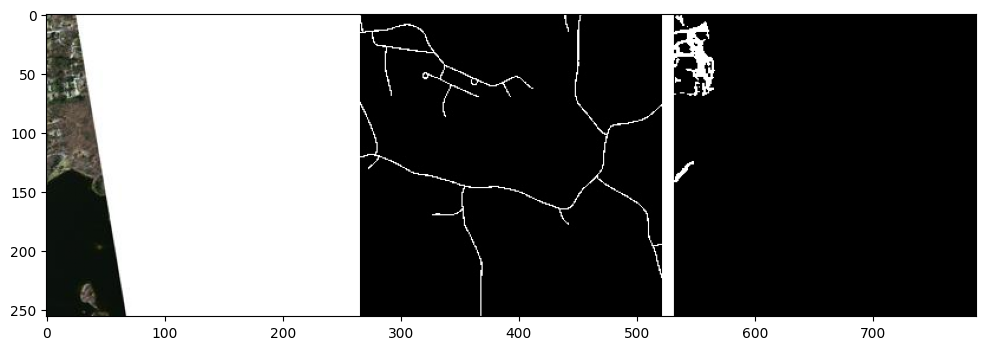

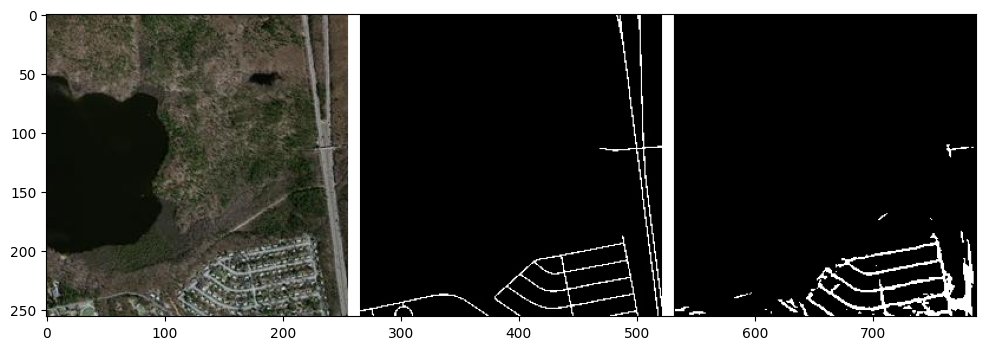

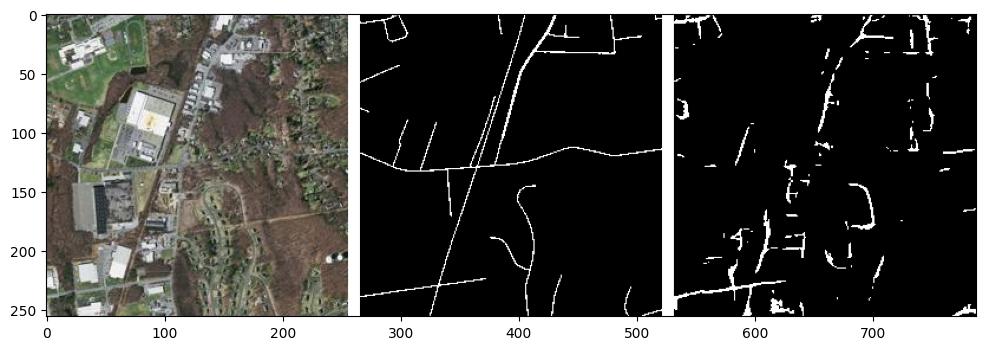

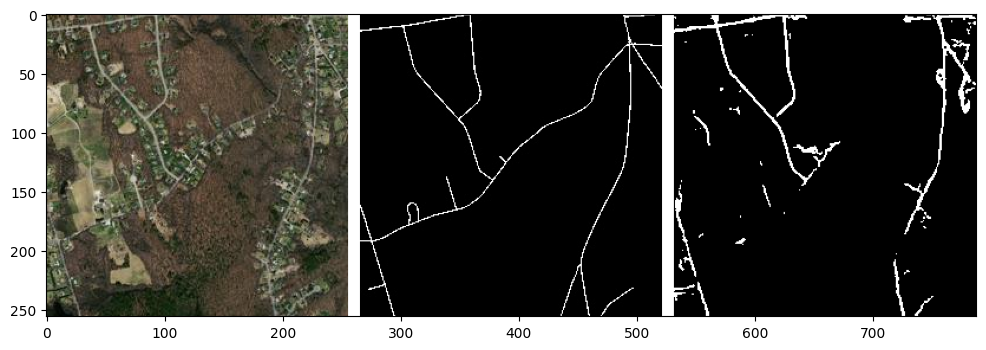

In [ ]:
for i, (a, b) in enumerate(zip(x_test[10:20], y_test[10:20])):
    a = read_img(a)
    b = read_mask(b)
    y_pred = model.predict(np.expand_dims(a, axis=0))[0] > 0.5
    h, w, _ = a.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        a, white_line,
        mask_parse(b), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    x = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)

In [ ]:
pred_dir = 'pred'
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)
for i, image in enumerate(imgs_mask_test):
    image = (image * 255).astype(np.uint8)
    # Apply thresholding to convert the predicted mask to binary format
    (ret, image) = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)
    cv2.imwrite(os.path.join(pred_dir, str(i + 1) + '_pred.png'), image)

NameError: ignored

In [ ]:
def tf_parse_2(a):
    def _parse_2(a):
        a = read_img(a)
        return a

    a = tf.numpy_function(_parse_2, [a], [tf.float64])
    a.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return a

def tf_dataset_2(a, batch=32):
    data = tf.data.Dataset.from_tensor_slices((a))
    data = data.map(tf_parse_2)
    data = data.batch(batch)
    data = data.repeat()
    return data

In [ ]:
testing = sorted(glob(os.path.join("/content/drive/My Drive/Datasets/Cologne_Roads/", "test/*")))
testing_masks = sorted(glob(os.path.join("/content/drive/My Drive/Datasets/Cologne_Roads/", "test_labels/*")))

print("Testing data: ", len(testing))
print("Masks data: ", len(testing_masks))



Testing data:  4
Masks data:  4


1/1 [==============================] - 0s 24ms/step


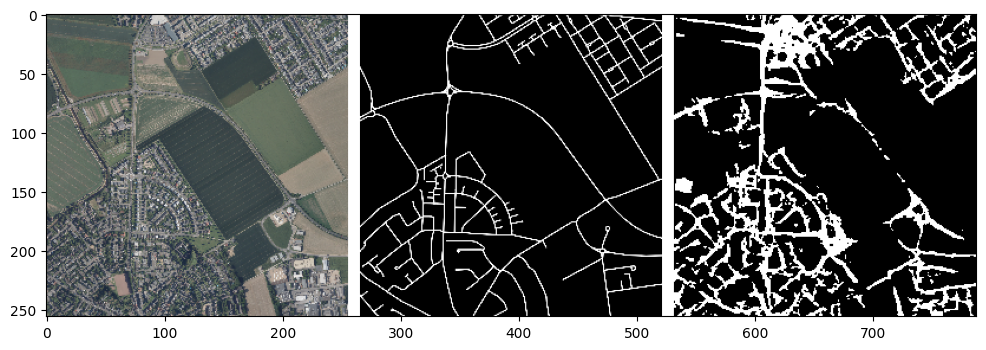

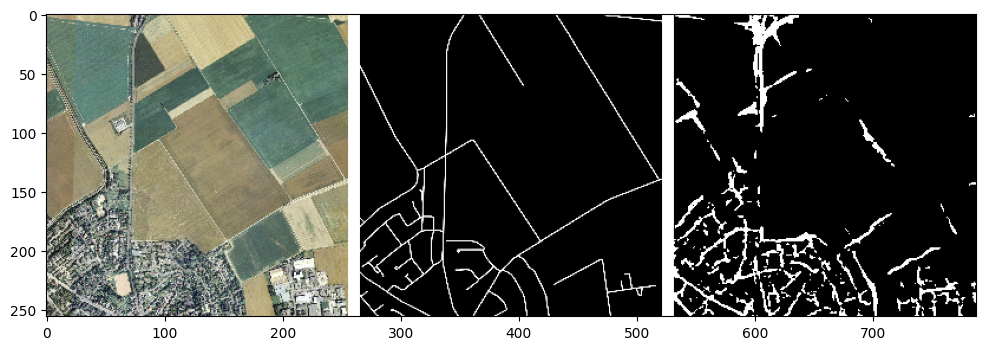

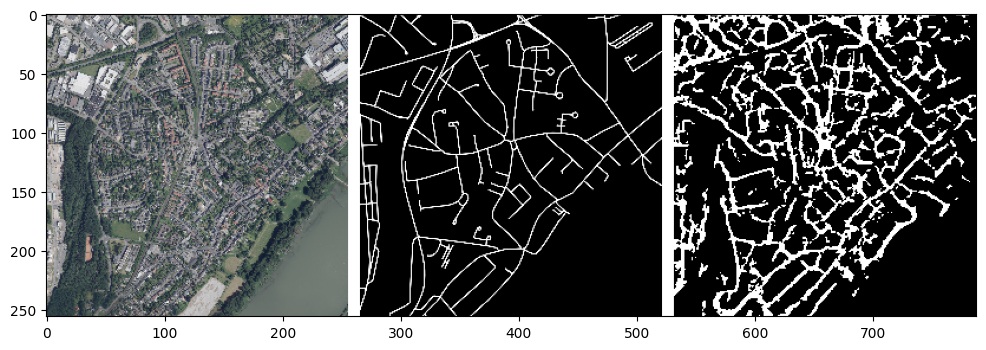

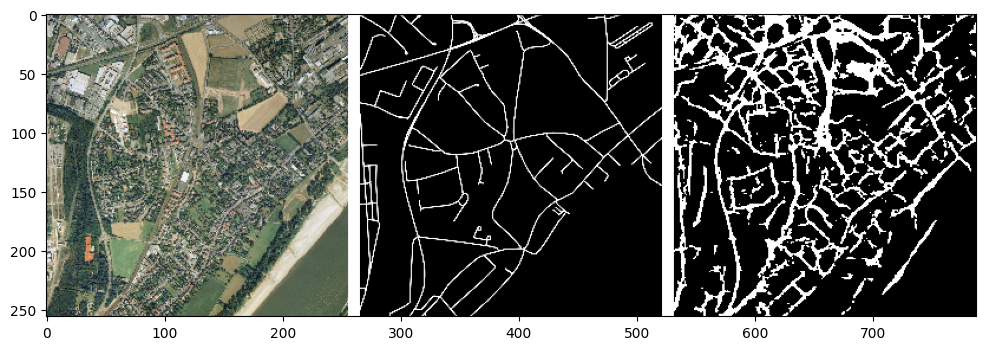

In [ ]:
for i, (a, b) in enumerate(zip(testing[0:20], testing_masks[0:20])):
    a = read_img(a)
    b = read_mask(b)
    y_pred = model.predict(np.expand_dims(a, axis=0))[0] > 0.5
    h, w, _ = a.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        a, white_line,
        mask_parse(b), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    x = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)